# **Assignment 2:** Convolutional Autoencoder

#### **Course:** SCC0270-SCC5809 Artificial Neural Networks

#### **Professor:** Moacir Antonelli Ponti

#### **Assistant:** Ana Letícia Garcez Vicente


---
### **Personal Info:**
*   **Student A:**
    *   André Zanardi Creppe
    *   11802972
*   **Student B:**
    *   Matheus Giraldi Alvarenga
    *   12543669

In this assignment you will practice building a Convolutional Autoencoder on the Google Colab environment and with PyTorch. The goals of this practice are the following:

-   Develop familiarity with uploading a dataset.
-   Gain experience with building a model.
-   Train a Convolutional Autoencoder.
-   Use visualization tools to evaluate your result.
- Use the trained Autoencoder as a feature extractor

# 1. Dataset

MNIST is a dataset of handwritten digits (0 - 9) with 60.000 samples for training and 10.000 for testing.

http://yann.lecun.com/exdb/mnist/

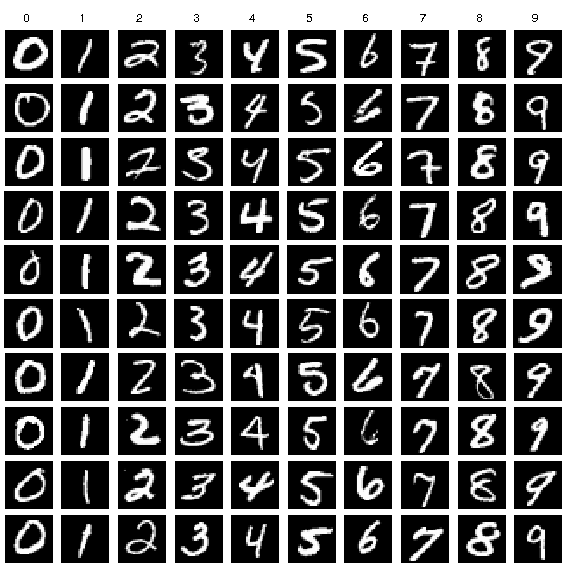

## Preparing Task: Download training and testing sets of MNIST using Pytorch framework

In [1]:
import torchvision
import torch

batch_size = 128

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 94117206.45it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 102919026.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29662968.30it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21333178.91it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# 2. Denoising Convolutional Autoencoder

The concept of an Autoencoder is illustrated in the image above, comprising two fundamental components: the encoder and the decoder. The encoder takes the input, which in our case is a noisy image, and transforms it into a latent space representation. Subsequently, the decoder receives this encoded image and endeavors to reconstruct the original image, this time removing the noise from it.


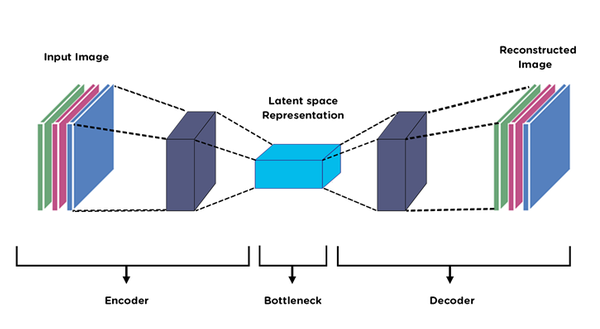

#### Adding noise to the images - Gaussian Noise

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"running on {device}")

running on cuda


In [3]:
def add_noise(x, stddev=0.2):
    noise = torch.randn(x.size()) * stddev
    if x.is_cuda:
        noise = noise.to(device)
    noisy_x = x + noise
    return torch.clamp(noisy_x, 0, 1)

Visualizing original samples and samples with Gaussian noise

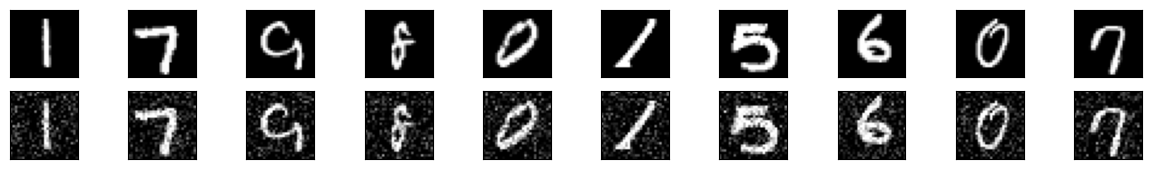

In [4]:
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
imgs, _ = next(dataiter)
noisy_imgs = add_noise(imgs)

n = 10
plt.figure(figsize=(15, 3))

for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(imgs[i].squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_imgs[i].squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## **Task 1:** (3 pts) Can you build a denoising Autoencoder?

#### Build a Denoising Autoencoder, following the configuration and parameters described in the instructions and image below

1. Implement a method for encoding, that takes an input image and generates a Vector of 128 dimensions,
2. Implement a method for decoding, that takes a vector of 128 dimensions and outputs an image,
3. The method `forward` will call the encoding and decoding methods.


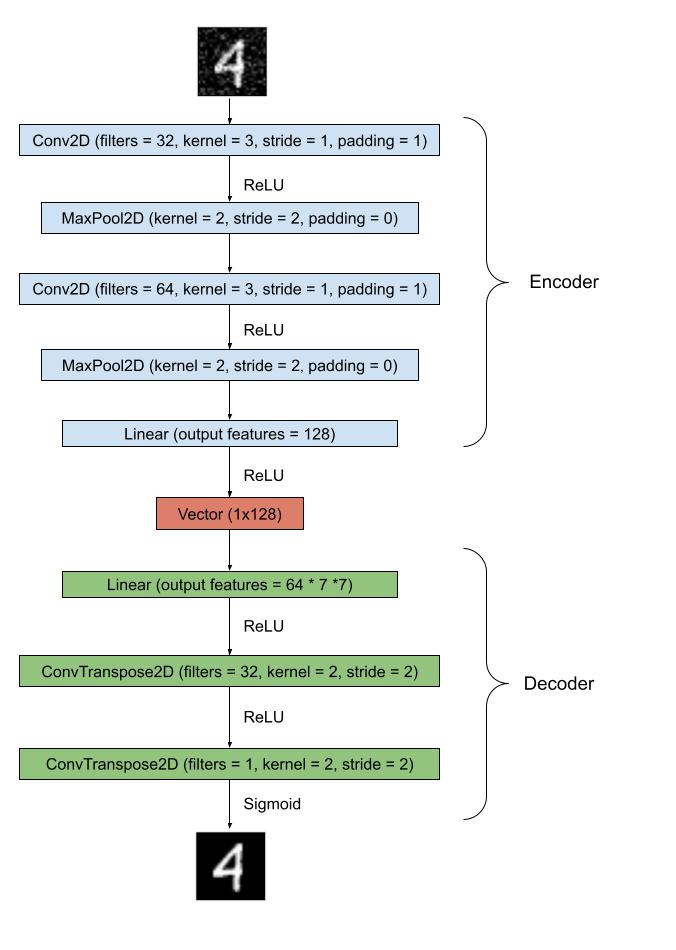


**Tip:** Be careful with dimensionality

When transitioning between convolutional and linear operations, it's essential to adapt the input of each layer accordingly.

Below, you can see an example on how to make this adjustment.

In [5]:
# Changing the organization of an tensor

dataiter = iter(test_loader)
imgs, _ = next(dataiter)

# Lets se the shape of 1 image
img = imgs[1]
print("Image shape:", img.shape, '\n')

# for flattening (to allow use linear layers) we need to change the dimension to a vector
vector = img.view(img.size(0), -1)
print("Vector shape:", vector.shape)
print("We can observe that the image 28x28 was transformed to a vector of 28*28 = 784", '\n')

# for the inverse
img = vector.view(vector.size(0), 28, 28)
print("Image shape:", img.shape, '\n')

Image shape: torch.Size([1, 28, 28]) 

Vector shape: torch.Size([1, 784])
We can observe that the image 28x28 was transformed to a vector of 28*28 = 784 

Image shape: torch.Size([1, 28, 28]) 



In [6]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

        self.linear_encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*7*7, out_features=128),
            nn.ReLU()
        )

        self.linear_decoder = nn.Sequential(
            nn.Linear(in_features=128, out_features=64*7*7),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_encoded = self.encoder(x)
        x_linear_encoded = self.linear_encoder(x_encoded)
        x_linear_decoded = self.linear_decoder(x_linear_encoded)
        x_linear_decoded = x_linear_decoded.view(-1, 64, 7, 7)
        x_decoded = self.decoder(x_linear_decoded)
        return x_decoded

In [7]:
autoencoder = Autoencoder().to(device)

# 3. Training

## **Task 2:** (3 pts) Training the Autoencoder

Use the BCE Loss and the Adam optimizer with an initial learning rate of 0.0005

In [8]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0005)

num_epochs = 40

In [9]:
def train_autoencoder(model, data_loader, num_epochs, criterion, optimizer, noise_level):
    saved_loss = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        for data in data_loader:
            inputs, _ = data # NO LABELS -> Unsupervised
            optimizer.zero_grad()

            noise_img = add_noise(inputs, stddev=noise_level)

            outputs = model(noise_img.cuda()) # Train with noisy images
            loss = criterion(outputs.cuda(), inputs.cuda()) # Calculate the loss with the original images

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(data_loader)
        saved_loss.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {epoch_loss}")

    print("Finished Training")

    return saved_loss

def test_autoencoder(model, data_loader, criterion, noise_level):
    model.eval()

    with torch.no_grad():
        test_loss = 0.0

        for data in data_loader:
            inputs, _ = data

            noise_img = add_noise(inputs, stddev=noise_level)

            outputs = model(noise_img.cuda()) # test with a noisy image
            test_loss += criterion(outputs.cuda(), inputs.cuda()).item() # calculate the loss with the original images

        saved_loss = test_loss / len(data_loader)
        print(f"Test Loss: {saved_loss}\n")

        return saved_loss

In [10]:
noise_level = 0.2 # noise level -> is going to be used afterwards in this assignment

train_autoencoder(autoencoder, train_loader, num_epochs, criterion, optimizer, noise_level=noise_level)
test_autoencoder(autoencoder, test_loader, criterion, noise_level=noise_level)

Epoch [1/40] Loss: 0.23727767592045798
Epoch [2/40] Loss: 0.11600694748193724
Epoch [3/40] Loss: 0.10029815223171258
Epoch [4/40] Loss: 0.09360183576848716
Epoch [5/40] Loss: 0.08975767631774773
Epoch [6/40] Loss: 0.08713757874233637
Epoch [7/40] Loss: 0.08528846472120488
Epoch [8/40] Loss: 0.08394095080811331
Epoch [9/40] Loss: 0.08286810543999742
Epoch [10/40] Loss: 0.08200723971766449
Epoch [11/40] Loss: 0.08129542433758026
Epoch [12/40] Loss: 0.08071871117742331
Epoch [13/40] Loss: 0.08021467785908977
Epoch [14/40] Loss: 0.0797853885428992
Epoch [15/40] Loss: 0.07937026741916436
Epoch [16/40] Loss: 0.07900685014755232
Epoch [17/40] Loss: 0.07868356524563547
Epoch [18/40] Loss: 0.07840571678015215
Epoch [19/40] Loss: 0.07811004870227659
Epoch [20/40] Loss: 0.07787883200688657
Epoch [21/40] Loss: 0.0776833237202437
Epoch [22/40] Loss: 0.07747898884673617
Epoch [23/40] Loss: 0.07730554814722493
Epoch [24/40] Loss: 0.07717144160446074
Epoch [25/40] Loss: 0.07700982845541257
Epoch [26/4

0.07541926723869541

## **Task 2.1**: (0.5 pt) Name another loss function that could be used for training. Which images do we use for calculating the loss?

Answer: Another loss function that we coud use is **MSEloss**. We are calculating the loss using the test images separated from our dataset. These images are the _pure_ form of our input data whereas the images that our model learns are with _noise_.

# 4. Visualizing the results

In [11]:
def plotResults(imgs, noisy_imgs, denoised_imgs, n, title=''):
  plt.figure(figsize=(15, 3))
  plt.suptitle(title)

  for i in range(n):
      # Original images
      ax = plt.subplot(3, n, i + 1)
      plt.imshow(imgs[i].squeeze().numpy(), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Noisy images
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(noisy_imgs[i].squeeze().numpy(), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Denoised images
      ax = plt.subplot(3, n, i + 1 + 2 * n)
      plt.imshow(denoised_imgs[i].detach().squeeze().numpy(), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

  plt.show()

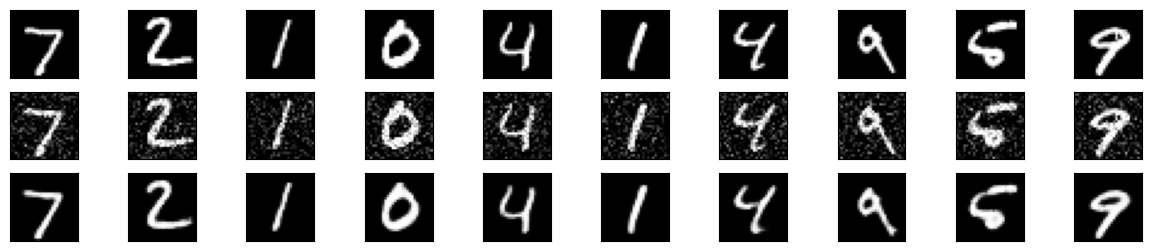

In [12]:
dataiter = iter(test_loader)
imgs, _ = next(dataiter)

imgs = imgs.cuda()
noisy_imgs = add_noise(imgs)
denoised_imgs = autoencoder(noisy_imgs)

imgs = imgs.to(torch.device('cpu'))
noisy_imgs = noisy_imgs.to(torch.device('cpu'))
denoised_imgs = denoised_imgs.to(torch.device('cpu'))

plotResults(imgs, noisy_imgs, denoised_imgs, n=10)

# 5. Experimenting with different noise levels.

## **Task 3:** (3 pts): run an experiment, training 5 denoising autoencoders

Each model will be trained with images using different noise levels, parametrized by the following standard deviation values: 0.1, 0.2, 0.3, 0.4 and 0.5. Use 25 epochs for training.

After training:
1. On a single plot, show the curves of the loss functions evaluated on the training set for the 5 models.
2. Compare the 5 models, by:
  1. evaluating the average loss function value on the test set,
  2. showing images reconstructed by the 5 models

In [13]:
num_epochs = 25

criterion = nn.BCELoss()

noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
train_loss = []
test_loss = []

n = 10
dataiter = iter(test_loader)
imgs, _ = next(dataiter)

encoder_imgs = imgs.cuda()[:n]
encoder_noisy_imgs = []
encoder_denoised_imgs = []

In [14]:
for i, noise in enumerate(noise_levels):
  torch.cuda.empty_cache()

  print(f'Iteration: {i + 1} // Noise: {noise}')

  new_autoencoder = Autoencoder().to(device)
  new_optimizer = torch.optim.Adam(new_autoencoder.parameters(), lr=0.0005)

  loss = train_autoencoder(new_autoencoder, train_loader, num_epochs, criterion, new_optimizer, noise_level=noise)
  train_loss.append(loss)

  loss = test_autoencoder(new_autoencoder, test_loader, criterion, noise_level=noise)
  test_loss.append(loss)

  noisy_imgs = add_noise(encoder_imgs, noise)
  denoised_imgs = new_autoencoder(noisy_imgs)

  encoder_noisy_imgs.append(noisy_imgs)
  encoder_denoised_imgs.append(denoised_imgs)

Iteration: 1 // Noise: 0.1
Epoch [1/25] Loss: 0.18770618716091997
Epoch [2/25] Loss: 0.10332904929227667
Epoch [3/25] Loss: 0.09218222701918087
Epoch [4/25] Loss: 0.08714581477934363
Epoch [5/25] Loss: 0.08406019701695899
Epoch [6/25] Loss: 0.08198197379803607
Epoch [7/25] Loss: 0.08043930820945992
Epoch [8/25] Loss: 0.07926114629517232
Epoch [9/25] Loss: 0.0782955114298792
Epoch [10/25] Loss: 0.0774501567519804
Epoch [11/25] Loss: 0.07679481516832481
Epoch [12/25] Loss: 0.07620622956358802
Epoch [13/25] Loss: 0.0756866370023949
Epoch [14/25] Loss: 0.07524270867742201
Epoch [15/25] Loss: 0.07482883637584349
Epoch [16/25] Loss: 0.07447801355614082
Epoch [17/25] Loss: 0.07417477584723979
Epoch [18/25] Loss: 0.07386579609184123
Epoch [19/25] Loss: 0.07363005470174716
Epoch [20/25] Loss: 0.07340814605323491
Epoch [21/25] Loss: 0.07318830035769863
Epoch [22/25] Loss: 0.0729721387756913
Epoch [23/25] Loss: 0.07280669186605827
Epoch [24/25] Loss: 0.07264008212572476
Epoch [25/25] Loss: 0.0725

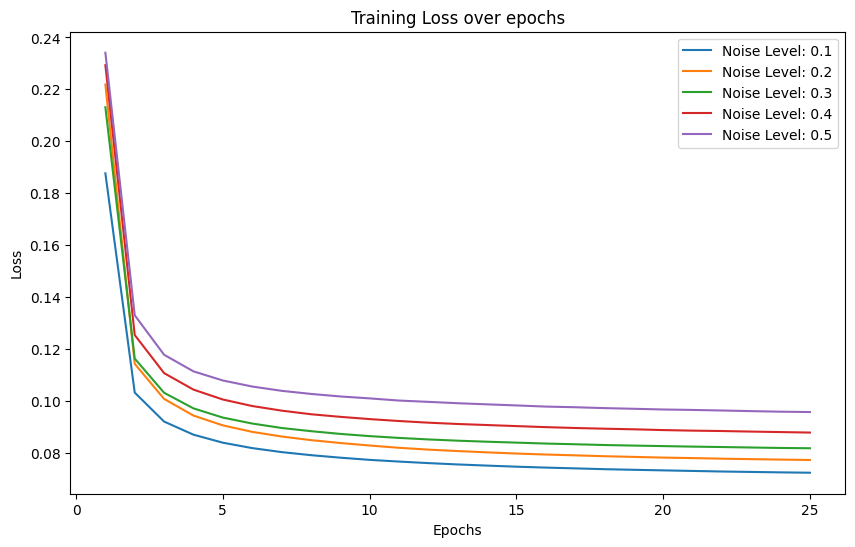

In [15]:
plt.figure(figsize=(10, 6))

for i, loss in enumerate(train_loss):
    plt.plot(range(1, num_epochs+1), loss, label=f'Noise Level: {noise_levels[i]}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.legend()
plt.show()

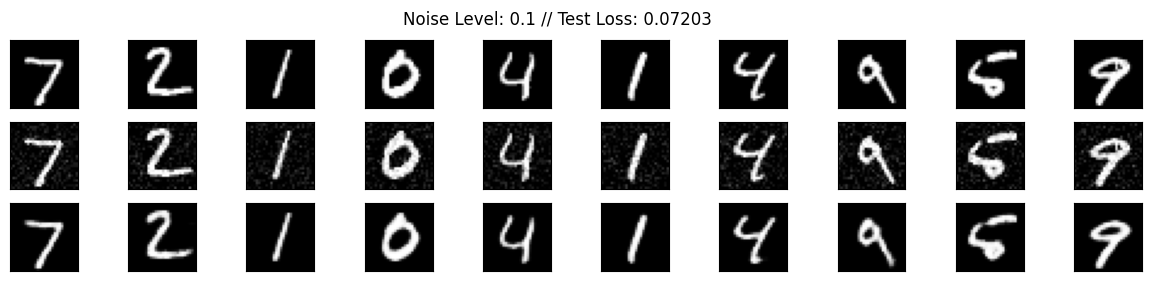

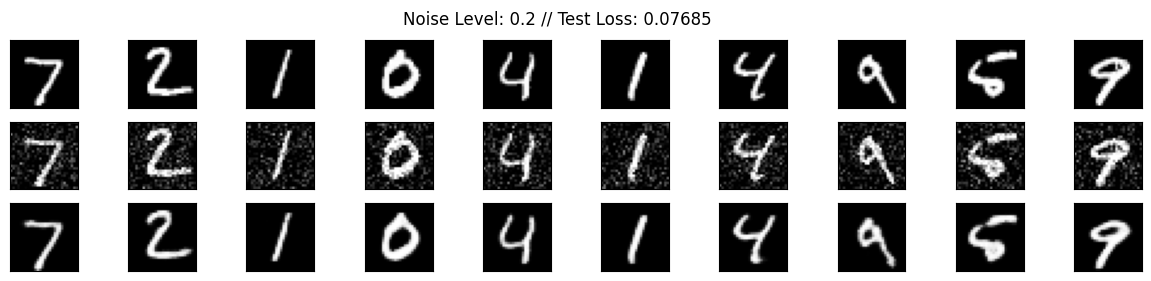

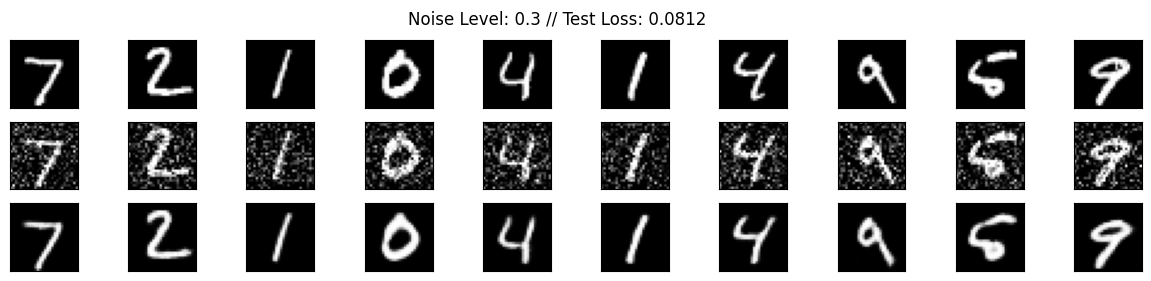

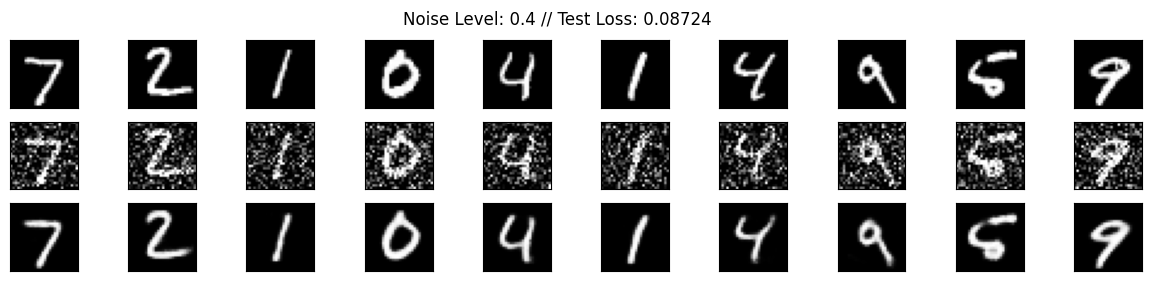

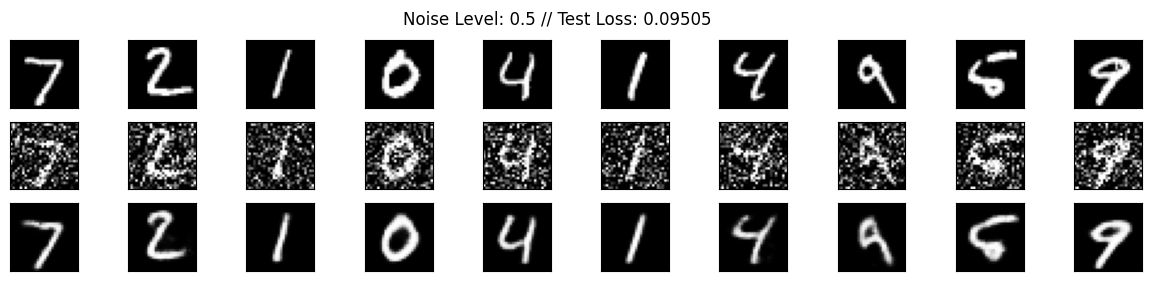

In [16]:
import numpy as np

for j in range(5):
  imgs = encoder_imgs
  noisy_imgs = encoder_noisy_imgs[j]
  denoised_imgs = encoder_denoised_imgs[j]

  imgs = imgs.to(torch.device('cpu'))
  noisy_imgs = noisy_imgs.to(torch.device('cpu'))
  denoised_imgs = denoised_imgs.to(torch.device('cpu'))

  title_text = f'Noise Level: {noise_levels[j]} // Test Loss: {np.round(test_loss[j], 5)}'
  plotResults(imgs, noisy_imgs, denoised_imgs, title=title_text, n=10)

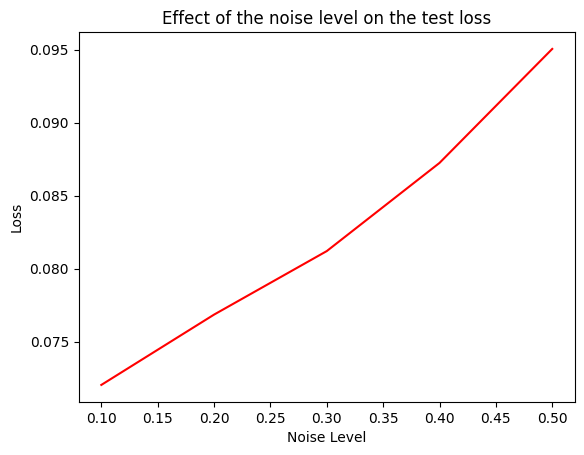

In [17]:
plt.plot(noise_levels, test_loss, 'r')
plt.xlabel("Noise Level")
plt.ylabel("Loss")
plt.title("Effect of the noise level on the test loss")
plt.show()

In [18]:
average_test_loss = sum(test_loss) / len(test_loss)
print(f'Average Test Loss: {average_test_loss}')

Average Test Loss: 0.08247640180059626


## **Task 3.1**: (0.5 pt) Write your observations about the experiments

Answer:

Testing the autoencoder with five different noise levels during training unveiled an interesting finding: as noise levels increased, the autoencoder faced more challenges in optimization. The denoising process appeared to struggle with high noise levels, leading to some denoised images being slightly fuzzy and exhibiting unusual features. This observation highlights the importance of balancing noise levels during training for optimal denoising performance.

Overall, the experiments were enjoyable and informative. The process of working with the autoencoder enhanced your expertise in the subject matter, underlining the value of hands-on experience and experimentation in deep learning and image processing.

# 6. Encoder as a feature extractor

## **Task 4:** optional/extra (1 pt) Training an external classifier

Use one of the trained models of your choice trained in task 3.

1. Use the `encoding` function to obtain a dataset of 128-dimensional features for all images of the training and testing sets. Convert those into numpy arrays.
2. Train a `LogisticRegression` classifier using the `sklearn` library using the training dataset (with 128 features obtained in step 1), see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for more information about this method.
3. Compute and print the accuracy score of the model for the training and testing sets.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def extract_features(data_loader, model):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for data in data_loader:
            inputs, targets = data
            encoded = model.linear_encoder(model.encoder(inputs.to(device))
                    .view(inputs.size(0), -1)
                    .to(device))
            features.append(encoded.cpu().numpy())
            labels.append(targets.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

In [20]:
train_features, train_labels = extract_features(train_loader, autoencoder)
test_features, test_labels = extract_features(test_loader, autoencoder)

print(train_features.shape)
print(train_labels.shape)

(60000, 128)
(60000,)


In [21]:
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_features, train_labels)

train_predictions = classifier.predict(train_features)
test_predictions = classifier.predict(test_features)

train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f"Training Set Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Set Accuracy: {test_accuracy * 100:.2f}%")

Training Set Accuracy: 92.47%
Testing Set Accuracy: 92.93%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


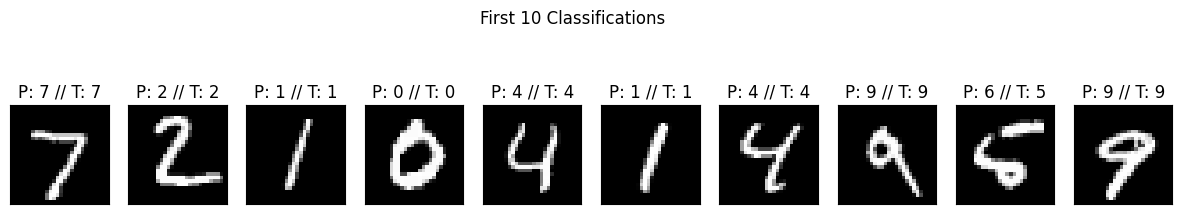

In [22]:
n = 10

plt.figure(figsize=(15, 3))
plt.suptitle('First 10 Classifications\n')

for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(imgs[i].squeeze().numpy(), cmap='gray')
    plt.title(f'P: {test_predictions[i]} // T: {test_labels[i]}') # P = prediction, T = target
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)